In [1]:
import sys
import time
from math import sqrt, ceil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StructType, StructField, StringType, DateType
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Tokenizer
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.sql.types import (
    StructType, StructField, StringType,
    ArrayType, IntegerType, DateType
)
#Spark NLP
from sparknlp.annotator import *
from sparknlp.base import *
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

#### Params

In [2]:
num_topics = 10
max_iterations = 100
vocabSize = 3000
minDF = 0.02
maxDF = 0.5

inputfile = "../../data/nytimes.tsv"
stopwordfile = "../stopwords/custom_stopwords.txt"

print("Parameters used in model:\nnum_topics: {}\nmax_iterations: {}".format(num_topics, max_iterations))
print("vocabSize: {}\nminDF: {}\nmaxDF: {}".format(vocabSize, minDF, maxDF))

Parameters used in model:
num_topics: 10
max_iterations: 100
vocabSize: 3000
minDF: 0.02
maxDF: 0.5


#### Create Spark session

In [3]:
spark = SparkSession.builder \
                    .appName("TopicModel") \
                    .config("spark.jars.packages",
                            "JohnSnowLabs:spark-nlp:2.3.4") \
                    .getOrCreate()
sc = spark.sparkContext

In [4]:
print("Apache Spark version: ", spark.version)

Apache Spark version:  2.4.0


In [5]:
# define schema for data
schema = StructType([
    StructField("date", DateType(), True),
    StructField("headline", StringType(), True),
    StructField("content", StringType(), True)])

In [6]:
df = spark.read \
          .option("header", "false") \
          .csv(inputfile, sep='\t', schema=schema) \
          .toDF("date", "headline", "content") \
          .drop("headline")
df.show(5)

+----------+--------------------+
|      date|             content|
+----------+--------------------+
|2016-06-30|Stellar pitching ...|
|2016-06-30|Mayor Bill de Bla...|
|2016-06-30|In the early morn...|
|2016-06-30|It was the Apple ...|
|2016-06-30|The United States...|
+----------+--------------------+
only showing top 5 rows



#### (Optional) Run tests on a subset of the full data

In [7]:
df1 = df.limit(2000)

### Spark NLP pipeline

In [8]:
document_assembler = DocumentAssembler() \
    .setInputCol("content")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True) 

# Read in a custom stopword list (vetted by experts if possible)
stopwords = sc.textFile(stopwordfile).collect()
stopWordsCleaner = StopWordsCleaner() \
      .setInputCols("normalized") \
      .setOutputCol("cleanTokens") \
      .setStopWords(stopwords) \
      .setCaseSensitive(False)

# Use default pretrained lemmatizer dictionary for now
lemmatizer = LemmatizerModel.pretrained(name="lemma_antbnc", lang="en") \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma") \

finisher = Finisher() \
    .setInputCols(["lemma"]) \
    .setIncludeMetadata(False)

nlpPipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector, 
    tokenizer,
    normalizer,
    stopWordsCleaner,
    lemmatizer,
    finisher
])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [9]:
nlpPipelineDF = nlpPipeline.fit(df1) \
                .transform(df1) \
                .withColumnRenamed('finished_lemma', 'text')
nlpPipelineDF.persist()
nlpPipelineDF.show(5)

+----------+--------------------+--------------------+
|      date|             content|                text|
+----------+--------------------+--------------------+
|2016-06-30|Stellar pitching ...|[stellar, pitch, ...|
|2016-06-30|Mayor Bill de Bla...|[mayor, bill, bla...|
|2016-06-30|In the early morn...|[early, morning, ...|
|2016-06-30|It was the Apple ...|[apple, store, ne...|
|2016-06-30|The United States...|[united, state, o...|
+----------+--------------------+--------------------+
only showing top 5 rows



In [10]:
nlpPipelineDF.count()

2000

### Spark ML pipeline

In [11]:
cv = CountVectorizer(inputCol="text",
                     outputCol="features",
                     vocabSize=vocabSize,
                     minDF=minDF,
                     maxDF=maxDF,
                     minTF=2.0)
idf = IDF(inputCol="features", outputCol="idf")

num_topics = 10
lda = LDA(k=num_topics,
          maxIter=max_iterations, 
          optimizer="online",
          seed=1,
          learningOffset=100.0,  # If high, early iterations are downweighted during training
          learningDecay=0.51,    # Set between [0.5, 1) to guarantee asymptotic convergence
         )

# Create Spark-NLP Pipeline
mlPipeline = Pipeline(stages=[
    cv,
    idf,
    lda
])

#### Train Spark ML pipeline using Spark-NLP pipeline

In [12]:
mlModel = mlPipeline.fit(nlpPipelineDF)
mlPipelineDF = mlModel.transform(nlpPipelineDF)
mlPipelineDF.show(5)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      date|             content|                text|            features|                 idf|   topicDistribution|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2016-06-30|Stellar pitching ...|[stellar, pitch, ...|(2513,[2,5,9,12,2...|(2513,[2,5,9,12,2...|[7.11942164001700...|
|2016-06-30|Mayor Bill de Bla...|[mayor, bill, bla...|(2513,[11,27,31,7...|(2513,[11,27,31,7...|[0.00130562482175...|
|2016-06-30|In the early morn...|[early, morning, ...|(2513,[5,7,11,25,...|(2513,[5,7,11,25,...|[0.00101301549177...|
|2016-06-30|It was the Apple ...|[apple, store, ne...|(2513,[0,1,2,6,11...|(2513,[0,1,2,6,11...|[9.25155444057115...|
|2016-06-30|The United States...|[united, state, o...|(2513,[6,7,10,12,...|(2513,[6,7,10,12,...|[7.99415882811581...|
+----------+--------------------+--------------------+--

#### Evaluate LDA model

In [13]:
ldaModel = mlModel.stages[2]

In [14]:
ll = ldaModel.logLikelihood(mlPipelineDF)
lp = ldaModel.logPerplexity(mlPipelineDF)
print("Lower bound on log likelihood of the corpus: " + str(ll))
print("Upper bound on perplexity: " + str(lp))

Lower bound on log likelihood of the corpus: -2055296.370296813
Upper bound on perplexity: 6.657628186363429


### Show top-n keywords for each topic

In [15]:
# Take top 15 words in each topic
topics = ldaModel.describeTopics(15)
topics_rdd = topics.rdd

vocab = mlModel.stages[0].vocabulary  # Vocab from countVectorizer

topic_words = topics_rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
        .collect()

topic_weights = topics_rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

for i, topic in enumerate(topic_words):
    words = ', '.join([word for word in topic])
    print("topic {}: {}".format(i + 1, words))
    print('-------------')

topic 1: school, student, family, university, college, child, know, tell, think, father, gun, law, high, work, mother
-------------
topic 2: test, water, find, human, small, project, south, flight, north, island, hong, animal, climate, area, kong
-------------
topic 3: car, park, customer, service, city, pay, vehicle, plan, recall, cost, company, owner, driver, app, golf
-------------
topic 4: trump, european, vote, britain, union, campaign, republican, leave, party, clinton, europe, country, political, british, democrat
-------------
topic 5: game, team, play, player, win, season, good, run, final, league, hit, go, second, mets, coach
-------------
topic 6: company, percent, bank, market, million, business, billion, price, deal, investor, financial, stock, fund, firm, executive
-------------
topic 7: united, country, american, attack, group, official, world, government, islamic, china, security, president, russian, news, kill
-------------
topic 8: work, go, think, know, art, way, loo

### Wordclouds of most likely words in each topic

#### Obtain a topic collection for visualizing topics more clearly
We convert the topic description from spark to a collection represented by `[topic_number, [(word, weight)]]`. This makes it easy to visualize as a wordcloud based on topic

In [16]:
topic_collection = []
for i, words in enumerate(topic_words):
    word_weights = list(zip(words, topic_weights[i]))
    topic_collection.append((i, word_weights))

In [17]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='cividis',
                     )
    # Define the size of the subplot matrix as a function of num_topics
    dim = ceil(sqrt(len(topics)))
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(len(topics)):
        print("Topic {}".format(i+1))
        ax = fig.add_subplot(dim, dim, i+1) 
        topic_words = dict(topics[i][1])
        wordcloud = cloud.generate_from_frequencies(topic_words)
        ax.imshow(wordcloud)
        ax.set_title('Topic {}'.format(i+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.margins(x=0, y=0);
    plt.tight_layout();

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9
Topic 10


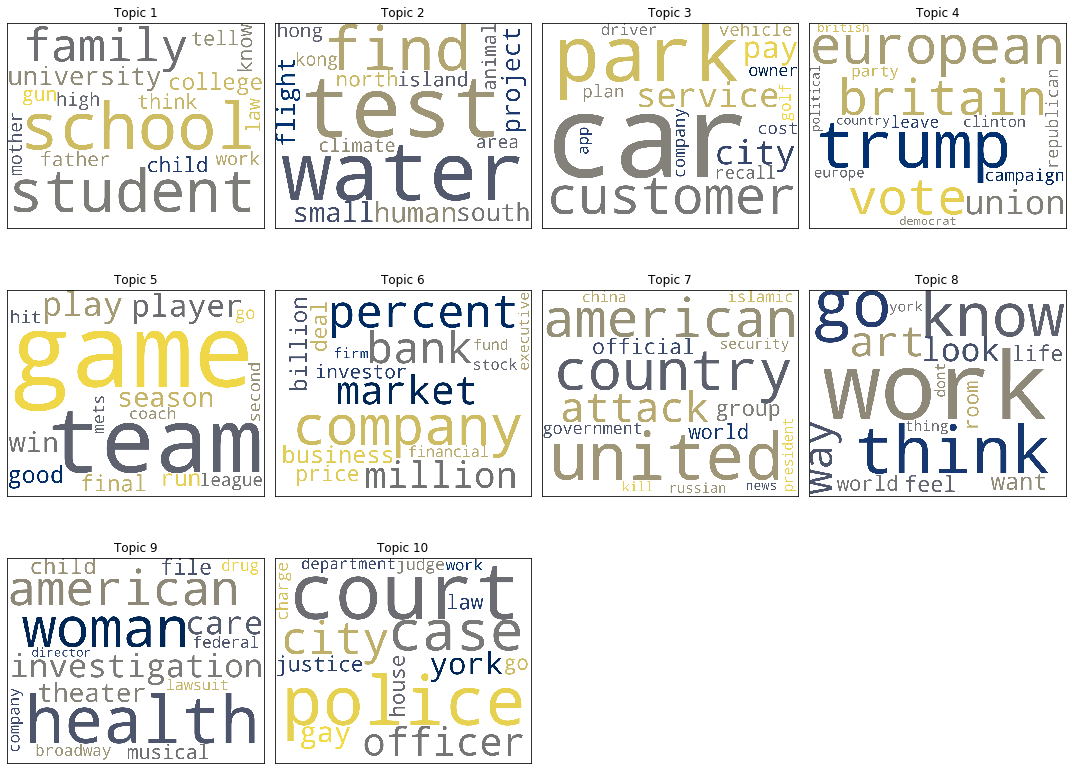

In [18]:
plot_wordclouds(topic_collection)

### Obtain topic distribution per document

In [19]:
transformed = mlModel.transform(nlpPipelineDF)
transformed.select('topicDistribution').show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topicDistribution                                                                                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[7.119421640017008E-4,4.4069639377993983E-4,4.2672715494363963E-4,5.000613839777932E-4,0.9945363723797606,4.950542824126351E-4,7.158867700923571E-4,8.836129125116532E-4,4.3588213872708853E-4,8.537644197926522E-4]|
|[0.00130562482175374,8.079466787047196E-4,7.823387699520915E-4,0.13930972104614434,0.0010899765793553325,9.076063276224221E-4,0.21286838706

In [20]:
topic_dist = transformed.select('date', 'text', 'topicDistribution')

#### Dominant topics (ranked by topic weight) per document

In [21]:
def sort_indices(topicVectors):
    # Convert topic weights to indices, and sort by highest values
    ordered = topicVectors.argsort()[-len(topicVectors):][::-1]
    ordered += 1    # Increment by one to avoid zero-indexing topics
    return ordered.tolist()
    
dominant_topics_udf = udf(sort_indices, ArrayType(IntegerType()))

dominantTopicsDF = topic_dist.withColumn('dominantTopics', dominant_topics_udf(topic_dist.topicDistribution))
dominantTopicsDF.show()

+----------+--------------------+--------------------+--------------------+
|      date|                text|   topicDistribution|      dominantTopics|
+----------+--------------------+--------------------+--------------------+
|2016-06-30|[stellar, pitch, ...|[7.11942164001700...|[5, 8, 10, 7, 1, ...|
|2016-06-30|[mayor, bill, bla...|[0.00130562482175...|[10, 7, 9, 4, 8, ...|
|2016-06-30|[early, morning, ...|[0.00101301549177...|[10, 7, 3, 8, 1, ...|
|2016-06-30|[apple, store, ne...|[9.25155444057115...|[6, 3, 8, 10, 5, ...|
|2016-06-30|[united, state, o...|[7.99415882811581...|[5, 7, 8, 2, 10, ...|
|2016-06-30|[race, olympic, t...|[0.00209841017904...|[5, 8, 10, 7, 1, ...|
|2016-06-30|[lionsgate, near,...|[0.00183616688586...|[8, 6, 7, 10, 1, ...|
|2016-06-30|[slatecolored, li...|[6.63869916631104...|[10, 2, 8, 9, 7, ...|
|2016-06-30|[jeff, hornacek, ...|[8.22132088002090...|[5, 10, 9, 6, 8, ...|
|2016-06-30|[long, time, pass...|[0.04487919302436...|[10, 4, 3, 1, 8, ...|
|2016-06-30|